# US Airline Flight Routes and Fares 1993-2024

## Business Understanding
This analysis aims to identify the key factors that influence airline fare prices using a dataset containing detailed information on U.S. domestic flight routes from 1993 to 2024. The insights derived from this analysis will help airlines, travel agencies, and policy makers optimize pricing strategies, improve route planning, and better understand competitive dynamics in the air travel market.

## Data Understanding
The dataset provides comprehensive information on airline flight routes, fares, and passenger volumes within the United States over a span of three decades. It includes metrics such as origin and destination cities and airports, distances between airports, number of passengers, and fare details segmented by different carriers (including the largest carrier and the lowest fare carrier). This rich set of features enables an in-depth analysis of air travel trends, pricing behavior, and market share dynamics.


### Data Dictionary
- `tbl`: Table identifier
- `year`: Year of the data record
- `quarter`: Quarter of the year (1–4)
- `citymarketid_1`: Origin city market ID
- `citymarketid_2`: Destination city market ID
- `city1`: Origin city name
- `city2`: Destination city name
- `airportid_1`: Origin airport ID
- `airportid_2`: Destination airport ID
- `airport_1`: Origin airport code
- `airport_2`: Destination airport code
- `nsmiles`: Distance between airports in miles
- `passengers`: Number of passengers
- `fare`: Average fare
- `carrier_lg`: Code for the largest carrier by passengers
- `large_ms`: Market share of the largest carrier
- `fare_lg`: Average fare of the largest carrier
- `carrier_low`: Code for the lowest fare carrier
- `lf_ms`: Market share of the lowest fare carrier
- `fare_low`: Lowest fare
- `Geocoded_City1`: Geocoded coordinates for the origin city
- `Geocoded_City2`: Geocoded coordinates for the destination city
- `tbl1apk`: Unique identifier for the route

In [ ]:
# Remember to install ace_tools_open and pmdarima
# pip install ace_tools_open pmdarima in terminal and restart kernel

# Standard library imports
import os
import warnings
import time
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor


# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SHAP
import shap

# Joblib
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## Data Loading

Let's load the dataset and perform an initial exploration to understand its structure and contents.

In [ ]:
# Download dataset
filename = 'us-airline-flight-routes-and-fares-1993-2024.zip'
if not os.path.exists(filename):
  !curl -L -o us-airline-flight-routes-and-fares-1993-2024.zip \
    https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024

# Load the dataset
data = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Basic statistics
print("\nBasic statistics:")
display(data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
display(data.isnull().sum().sort_values(ascending=False))

# Check data types
print("\nData types:")
display(data.dtypes)

Dataset shape: (245955, 23)

First 5 rows:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX



Basic statistics:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
count,245955,245955.000000,245955.000000,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955.000000,244415,244415.000000,244415.000000,244343,244343.000000,244343.000000,206749,206749,245955
unique,2,NaN,NaN,NaN,NaN,141,128,NaN,NaN,187,173,NaN,NaN,NaN,67,NaN,NaN,71,NaN,NaN,238,207,245955
top,Table 1a,NaN,NaN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",NaN,NaN,ORD,DCA,NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",202131013514112ABEPIE
freq,200897,NaN,NaN,NaN,NaN,26055,36913,NaN,NaN,8819,10268,NaN,NaN,NaN,58999,NaN,NaN,56027,NaN,NaN,21028,30688,1
mean,NaN,2008.524124,2.479153,31556.430201,32180.117086,NaN,NaN,12437.099986,13249.889525,NaN,NaN,1189.812319,299.476795,218.979587,NaN,0.665252,218.710963,NaN,0.450438,190.675939,NaN,NaN,NaN
std,NaN,8.703364,1.122149,1089.872880,1232.464184,NaN,NaN,1431.665257,1425.810159,NaN,NaN,703.143472,511.389486,82.372486,NaN,0.224635,84.674363,NaN,0.332669,73.577694,NaN,NaN,NaN
min,NaN,1993.000000,1.000000,30135.000000,30189.000000,NaN,NaN,10135.000000,10466.000000,NaN,NaN,109.000000,0.000000,50.000000,NaN,0.003800,50.000000,NaN,0.010000,50.000000,NaN,NaN,NaN
25%,NaN,2001.000000,1.000000,30721.000000,30994.000000,NaN,NaN,11193.000000,12197.000000,NaN,NaN,626.000000,21.000000,164.620000,NaN,0.480000,161.500000,NaN,0.158000,140.060000,NaN,NaN,NaN
50%,NaN,2008.000000,2.000000,31423.000000,32211.000000,NaN,NaN,12266.000000,13303.000000,NaN,NaN,1023.000000,113.000000,209.320000,NaN,0.652400,208.030000,NaN,0.360000,181.630000,NaN,NaN,NaN
75%,NaN,2016.000000,3.000000,32467.000000,33192.000000,NaN,NaN,13487.000000,14679.000000,NaN,NaN,1736.000000,339.000000,262.890000,NaN,0.871900,263.640000,NaN,0.750000,230.040000,NaN,NaN,NaN



Missing values per column:


Geocoded_City2    39206
Geocoded_City1    39206
fare_low           1612
lf_ms              1612
carrier_low        1612
fare_lg            1540
large_ms           1540
carrier_lg         1540
tbl                   0
passengers            0
fare                  0
nsmiles               0
Year                  0
airport_2             0
airport_1             0
airportid_2           0
airportid_1           0
city2                 0
city1                 0
citymarketid_2        0
citymarketid_1        0
quarter               0
tbl1apk               0
dtype: int64


Data types:


tbl                object
Year                int64
quarter             int64
citymarketid_1      int64
citymarketid_2      int64
city1              object
city2              object
airportid_1         int64
airportid_2         int64
airport_1          object
airport_2          object
nsmiles             int64
passengers          int64
fare              float64
carrier_lg         object
large_ms          float64
fare_lg           float64
carrier_low        object
lf_ms             float64
fare_low          float64
Geocoded_City1     object
Geocoded_City2     object
tbl1apk            object
dtype: object

## Data Cleaning and Preprocessing

In this section, we'll:
1. Handle missing values
2. Address outliers
3. Fix data types
4. Create new features if needed
5. Prepare data for analysis

In [ ]:
# Mapping: airport codes to airlines
airport_airline_map = {
    'DFW': ['American Airlines'],
    'CLT': ['American Airlines'],
    'ORD': ['American Airlines', 'United Airlines'],
    'LAX': ['American Airlines', 'Delta Air Lines', 'United Airlines'],
    'MIA': ['American Airlines'],
    'JFK': ['American Airlines', 'Delta Air Lines'],
    'LGA': ['American Airlines', 'Delta Air Lines'],
    'PHL': ['American Airlines'],
    'PHX': ['American Airlines', 'Southwest Airlines'],
    'DCA': ['American Airlines'],
    'ATL': ['Delta Air Lines'],
    'BOS': ['Delta Air Lines'],
    'DTW': ['Delta Air Lines'],
    'MSP': ['Delta Air Lines'],
    'SLC': ['Delta Air Lines'],
    'SEA': ['Delta Air Lines'],
    'DEN': ['United Airlines', 'Southwest Airlines'],
    'IAH': ['United Airlines'],
    'EWR': ['United Airlines'],
    'SFO': ['United Airlines'],
    'IAD': ['United Airlines'],
    'BWI': ['Southwest Airlines'],
    'MDW': ['Southwest Airlines'],
    'DAL': ['Southwest Airlines'],
    'HOU': ['Southwest Airlines'],
    'LAS': ['Southwest Airlines'],
    'OAK': ['Southwest Airlines'],
    'MCO': ['Southwest Airlines'],
}

def map_metropolitan_to_airport(city_name):
    if "Miami" in city_name:
        return "MIA"
    elif "New York" in city_name:
        return "JFK"  # or LGA
    elif "Boston" in city_name:
        return "BOS"
    elif "San Francisco" in city_name:
        return "SFO"
    elif "Los Angeles" in city_name:
        return "LAX"
    elif "Norfolk" in city_name:
        return "DCA"
    elif "Cleveland" in city_name:
        return "ORD"  # No Cleveland hub, ORD as major connection
    elif "Washington" in city_name:
        return "DCA"  # or IAD for United
    elif "Atlanta" in city_name:
        return "ATL"
    elif "Tampa" in city_name:
        return "MCO"  # or TPA if exact, but you can keep MCO for SWA logic
    else:
        return None

def map_airlines(airport_code):
    return airport_airline_map.get(airport_code, [])

def clean_airline_data(df):
    """Clean and preprocess the airline fare dataset for predictive modeling."""

    # Create a copy to avoid modifying the original dataframe
    df_clean = df.copy()

    # 1. Handle missing values
    missing_percent = df_clean.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns with >50% missing values: {cols_to_drop}")

    initial_rows = df_clean.shape[0]

    # Drop rows with any missing values
    required_cols = ['fare', 'passengers', 'nsmiles', 'quarter', 'Year']
    df_clean = df_clean.dropna(subset=required_cols)

    # Drop duplicates
    df_clean = df_clean.drop_duplicates()

    # Drop irrelevant identifier columns
    cols_to_remove = ['tbl', 'tbl1apk']
    for col in cols_to_remove:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
            print(f"Dropped column: {col}")

    dropped_rows = initial_rows - df_clean.shape[0]
    print(f"\nDropped {dropped_rows} rows with missing values")
    print(f"Shape after dropping NaN values: {df_clean.shape}")

    # 2. Handle outliers in numerical columns
    def remove_outliers_by_year(df, column, group_col='Year'):
        def iqr_filter(sub_df):
            if len(sub_df) < 100:  # Avoid filtering very small groups
                return sub_df
            Q1 = sub_df[column].quantile(0.25)
            Q3 = sub_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return sub_df[(sub_df[column] >= lower) & (sub_df[column] <= upper)]
        return df.groupby(group_col, group_keys=False).apply(iqr_filter)

    # 3. Convert data types if necessary
    if 'Year' in df_clean.columns:
        df_clean['Year'] = df_clean['Year'].astype(int)
    if 'quarter' in df_clean.columns:
        df_clean['quarter'] = df_clean['quarter'].astype(int)
    if 'passengers' in df_clean.columns:
        df_clean['passengers'] = df_clean['passengers'].astype(int)
    if 'nsmiles' in df_clean.columns:
        df_clean['nsmiles'] = df_clean['nsmiles'].astype(float)

    # 4. Create new features
    # fare per mile
    if 'fare' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['fare_per_mile'] = df_clean['fare'] / (df_clean['nsmiles'] + 1e-5)  # Add epsilon to avoid division by zero

    # passengers per mile
    if 'passengers' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['passengers_per_mile'] = df_clean['passengers'] / (df_clean['nsmiles'] + 1e-5)

    # fare per passenger
    if 'passengers' in df_clean.columns:
        df_clean['fare_per_passenger'] = df_clean['fare_per_mile'] / (df_clean['passengers_per_mile'] + 1e-5)

    # Create new 'revenue' and 'year_quarter' columns
    df_clean['revenue'] = df_clean['passengers'] * df_clean['fare']
    df_clean['year_quarter'] = df_clean['Year'].astype(str) + 'Q' + df_clean['quarter'].astype(str)

    # Extract numeric year and quarter for sorting
    df_clean['year_num'] = df_clean['Year'].astype(int)
    df_clean['quarter_num'] = df_clean['quarter'].astype(int)

    # Sort and define proper order
    ordered_quarters = (
        df_clean[['year_quarter', 'year_num', 'quarter_num']]
        .drop_duplicates()
        .sort_values(by=['year_num', 'quarter_num'])['year_quarter']
        .tolist()
    )

    df_clean['year_quarter'] = pd.Categorical(df_clean['year_quarter'], categories=ordered_quarters, ordered=True)

    # First, update airport_1 codes if city1 is Metropolitan
    if 'airport_1' in df_clean.columns and 'city1' in df_clean.columns:
        df_clean['airport_1'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city1']) if 'Metropolitan' in str(row['city1']) else row['airport_1'],
            axis=1
        )

    # Then, update airport_2 codes if city2 is Metropolitan
    if 'airport_2' in df_clean.columns and 'city2' in df_clean.columns:
        df_clean['airport_2'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city2']) if 'Metropolitan' in str(row['city2']) else row['airport_2'],
            axis=1
        )

    # Finally, map airlines based on updated airport_1 or airport_2
    if 'airport_1' in df_clean.columns:
        df_clean['airlines_1'] = df_clean['airport_1'].apply(map_airlines)
    if 'airport_2' in df_clean.columns:
        df_clean['airlines_2'] = df_clean['airport_2'].apply(map_airlines)

    df_clean['possible_airlines'] = [
        list(set(a1 + a2)) for a1, a2 in zip(df_clean['airlines_1'], df_clean['airlines_2'])
    ]


    numeric_cols = [col for col in ['fare', 'passengers', 'nsmiles', 'fare_per_mile', 'passengers_per_mile', 'revenue'] if col in df_clean.columns]


    # recent_years = df_clean['Year'] >= 2020
    # pre_2020 = df_clean[~recent_years]
    # post_2020 = df_clean[recent_years]

    # # Apply outlier removal only to pre-2020
    # for column in numeric_cols:
    #     if column not in ['fare', 'revenue', 'passengers', 'Year', 'year_quarter', 'year_num']:
    #         pre_2020 = remove_outliers_by_year(pre_2020, column)

    # # Recombine
    # df_clean = pd.concat([pre_2020, post_2020], axis=0)

    # Apply outlier removal
    for column in numeric_cols:
        if column not in ['fare', 'revenue', 'passengers', 'Year', 'year_quarter', 'year_num']:
            df_clean = remove_outliers_by_year(df_clean, column)


    print("Shape after removing outliers:", df_clean.shape)

    return df_clean

# Apply cleaning function
df_clean = clean_airline_data(data)

# Preview data using available columns
df_clean[['airport_1', 'airport_2', 'year_quarter', 'passengers', 'fare', 'revenue']].head()

# Find rows where city1 contains 'Metropolitan'
if 'city1' in df_clean.columns:
    metropolitan_city1 = df_clean.loc[df_clean['city1'].str.contains('Metropolitan', case=False, na=False), 'city1'].unique()
else:
    metropolitan_city1 = []

if 'city2' in df_clean.columns:
    metropolitan_city2 = df_clean.loc[df_clean['city2'].str.contains('Metropolitan', case=False, na=False), 'city2'].unique()
else:
    metropolitan_city2 = []

metropolitan_cities_set = set(metropolitan_city1).union(set(metropolitan_city2))


# Display unique cities
print("\nUnique set of Metropolitan cities:")
print(metropolitan_cities_set, len(metropolitan_cities_set))

print("\nCleaned dataset info:")
df_clean.info()
display(df_clean.head())

# print(df_clean['Year'].max())
# print(df_clean['Year'].value_counts().sort_index(ascending=False))

Dropped columns with >50% missing values: []
Dropped column: tbl
Dropped column: tbl1apk

Dropped 0 rows with missing values
Shape after dropping NaN values: (245955, 21)
Shape after removing outliers: (204203, 31)

Unique set of Metropolitan cities:
{'Boston, MA (Metropolitan Area)', 'Tampa, FL (Metropolitan Area)', 'Miami, FL (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'San Francisco, CA (Metropolitan Area)', 'Atlanta, GA (Metropolitan Area)', 'New York City, NY (Metropolitan Area)', 'Los Angeles, CA (Metropolitan Area)', 'Washington, DC (Metropolitan Area)', 'Norfolk, VA (Metropolitan Area)'} 10

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 204203 entries, 5923 to 245954
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Year                 204203 non-null  int32   
 1   quarter              204203 non-null  int32   
 2   citymarketid_1       204203 non-nu

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,fare_per_mile,passengers_per_mile,fare_per_passenger,revenue,year_quarter,year_num,quarter_num,airlines_1,airlines_2,possible_airlines
5923,1993,4,30255,30852,"Huntsville, AL","Washington, DC (Metropolitan Area)",12217,12264,HSV,DCA,640.0,21,242.76,DL,0.48,275.50,UA,0.25,197.69,"Huntsville, AL\n(34.729538, -86.585283)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.379312,0.032812,11.556478,5097.96,1993Q4,1993,4,[],[American Airlines],[American Airlines]
5930,1993,1,31453,32457,"Houston, TX","San Francisco, CA (Metropolitan Area)",12266,13796,IAH,SFO,1657.0,51,272.66,HP,0.64,230.26,HP,0.64,230.26,"Houston, TX\n(29.760803, -95.369506)","San Francisco, CA (Metropolitan Area)\n(37.78008, -122.420168)",0.164550,0.030779,5.344538,13905.66,1993Q1,1993,1,[United Airlines],[United Airlines],[United Airlines]
5961,1993,1,30599,32575,"Birmingham, AL","Los Angeles, CA (Metropolitan Area)",10599,12954,BHM,LAX,1815.0,2,290.64,AA,1.00,290.64,AA,1.00,290.64,"Birmingham, AL\n(33.522859, -86.807705)","Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)",0.160132,0.001102,144.013081,581.28,1993Q1,1993,1,[],"[American Airlines, Delta Air Lines, United Airlines]","[United Airlines, American Airlines, Delta Air Lines]"
5969,1993,1,31703,34524,"New York City, NY (Metropolitan Area)","Richmond, VA",15070,14524,JFK,RIC,325.0,4,173.52,US,0.81,178.83,US,0.81,178.83,"New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)","Richmond, VA\n(37.540759, -77.433932)",0.533908,0.012308,43.344782,694.08,1993Q1,1993,1,"[American Airlines, Delta Air Lines]",[],"[American Airlines, Delta Air Lines]"
5983,1993,1,33570,30852,"San Diego, CA","Washington, DC (Metropolitan Area)",14679,11278,SAN,DCA,2295.0,266,290.94,AA,0.26,343.23,NW,0.24,209.78,"San Diego, CA\n(32.71576, -117.163817)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.126771,0.115904,1.093665,77390.04,1993Q1,1993,1,[],[American Airlines],[American Airlines]


### Exploratory Data Analysis (EDA)

Now that our data is cleaned, let's explore the distributions and relationships between variables.

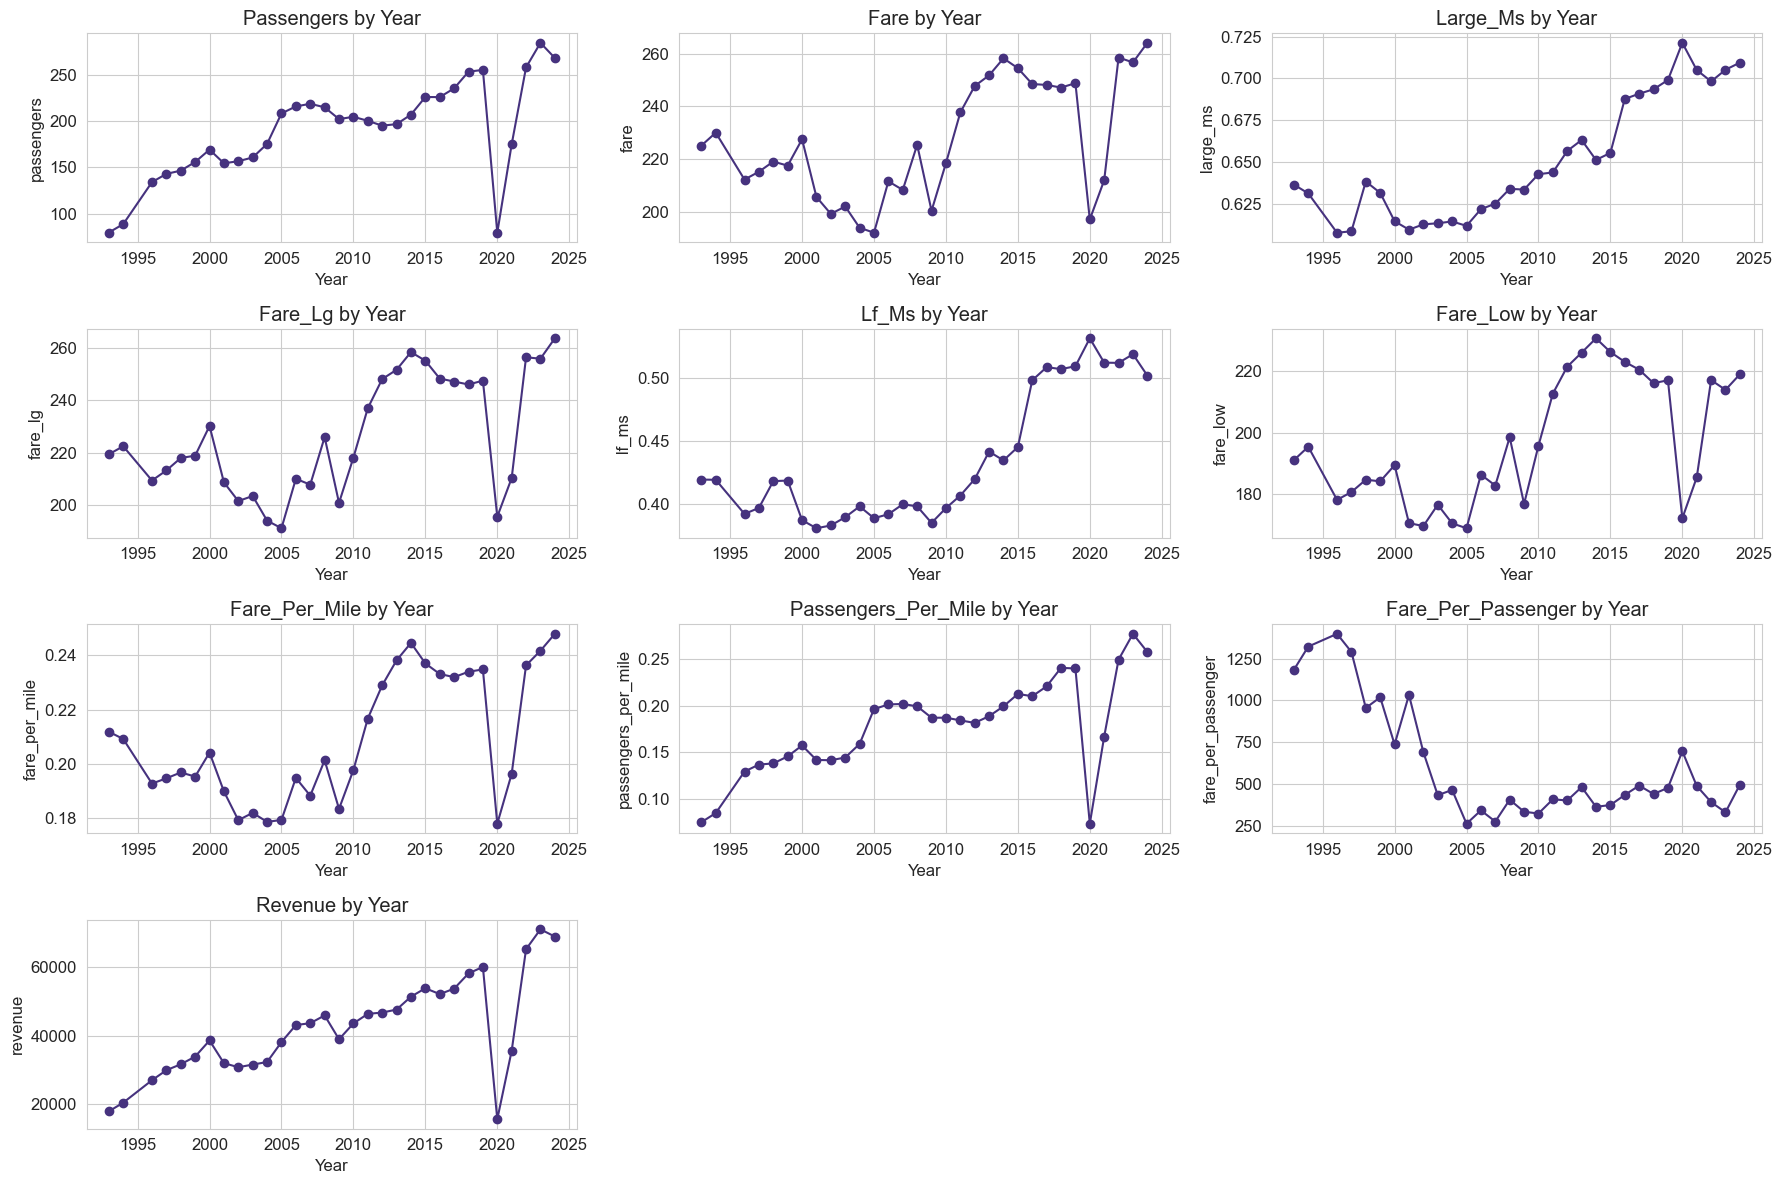

Skipped 'city1': 140 unique values
Skipped 'city2': 126 unique values
Skipped 'airport_1': 159 unique values
Skipped 'airport_2': 144 unique values
Skipped 'carrier_lg': 62 unique values
Skipped 'carrier_low': 63 unique values
Skipped 'Geocoded_City1': 233 unique values
Skipped 'Geocoded_City2': 203 unique values


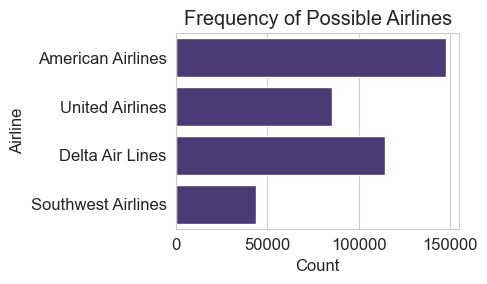

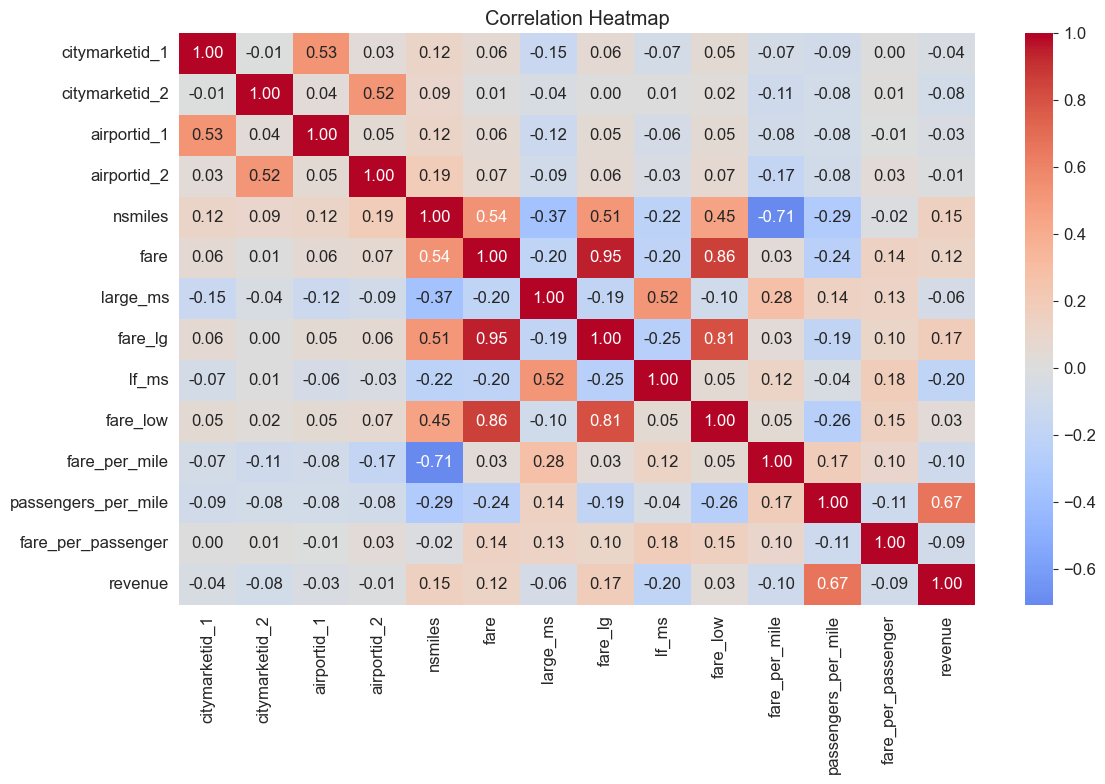

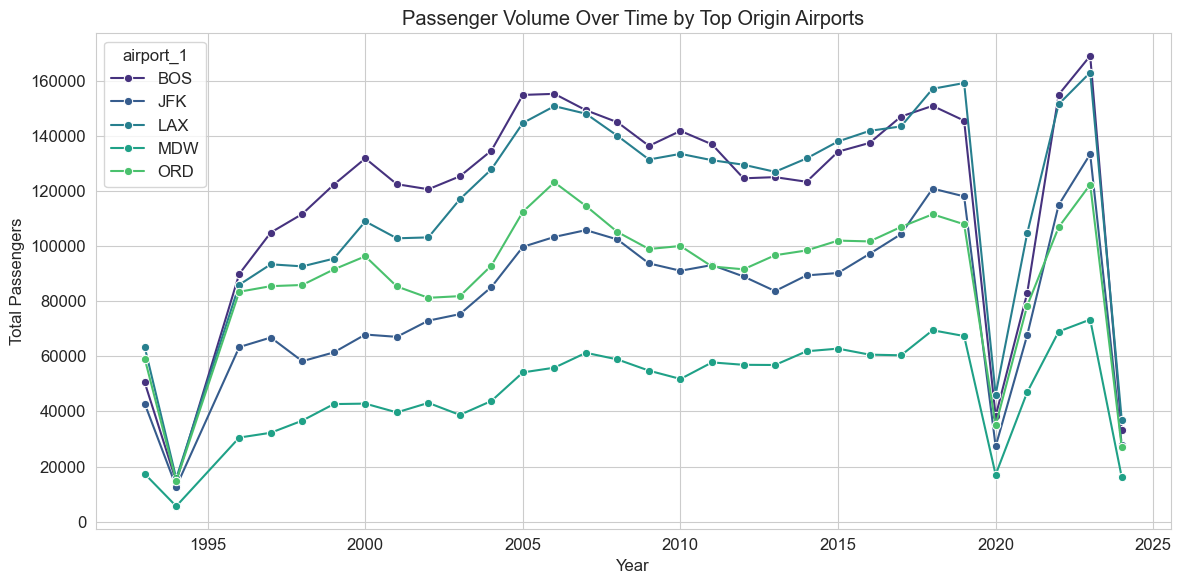

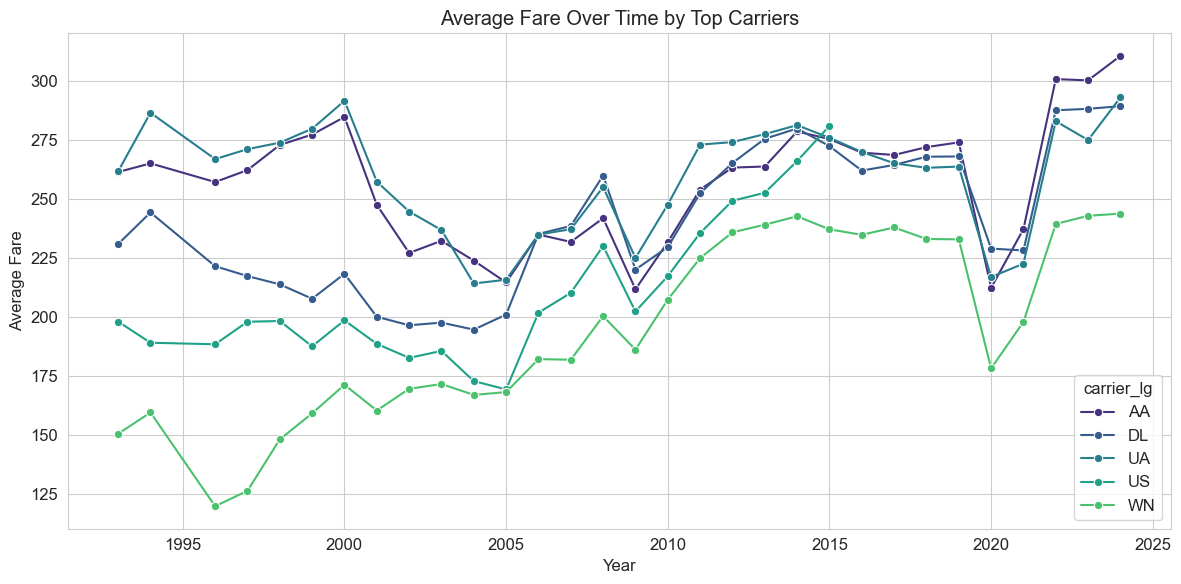

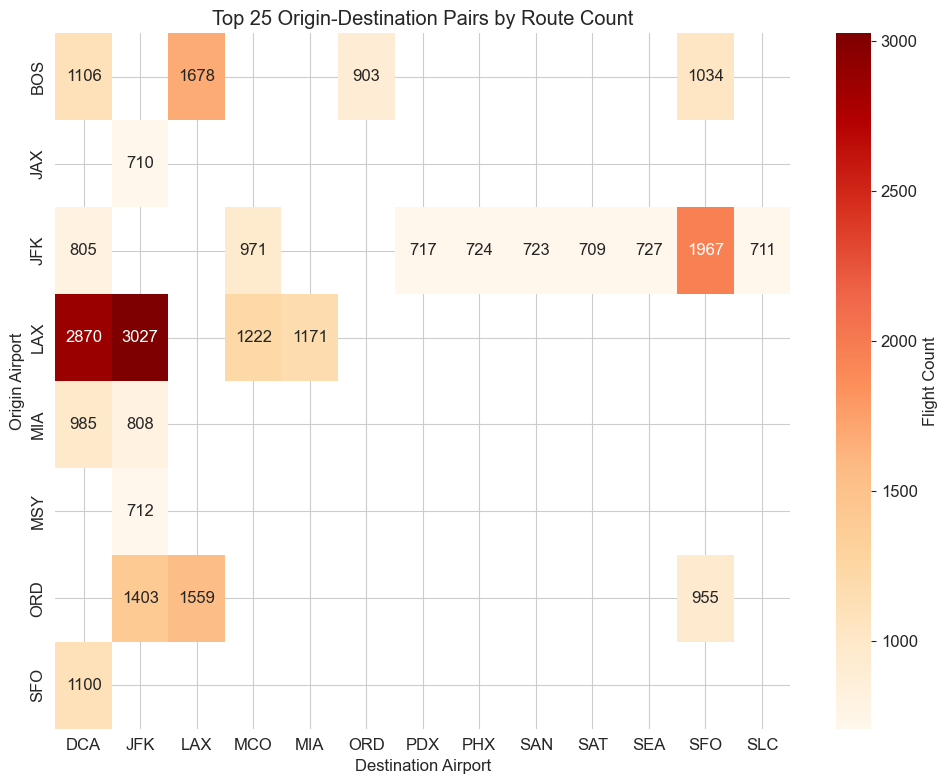

In [ ]:
def plot_distributions_by_year(df, columns, year_col='Year', ncols=3, figsize=(18, 12)):
    """Plot distribution of numerical columns grouped by year."""
    if year_col not in df.columns:
        raise ValueError(f"'{year_col}' column not found in DataFrame.")

    df = df.copy()

    # Ensure year is integer
    if not np.issubdtype(df[year_col].dtype, np.integer):
        df[year_col] = df[year_col].astype(int)

    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    i = 0
    for i, col in enumerate(columns):
        if col in df.columns and col.lower() not in ['year', 'quarter']:
            grouped = df.groupby(year_col)[col].mean().dropna()
            if len(grouped) > 1:
                axes[i].plot(grouped.index, grouped.values, marker='o')
                axes[i].set_title(f'{col.title()} by Year')
                axes[i].set_xlabel('Year')
                axes[i].set_ylabel(col)
                axes[i].grid(True)
            else:
                axes[i].text(0.5, 0.5, 'Not enough data to plot', ha='center', va='center')
                axes[i].set_title(f'{col.titl()} by Year')
                axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# # Plot distributions of numerical columns
# num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
# print(num_cols)
columns_to_plot = [
    'passengers', 'fare', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low',
    'fare_per_mile', 'passengers_per_mile', 'fare_per_passenger', 'revenue'
]
plot_distributions_by_year(df_clean, columns_to_plot)

cat_cols = [
    col for col in df_clean.select_dtypes(include=['object']).columns
    if not df_clean[col].apply(lambda x: isinstance(x, list)).any()
]

for col in cat_cols:
    unique_vals = df_clean[col].nunique()
    if unique_vals < 60:
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_clean,
                      order=df_clean[col].value_counts().index)
        plt.title(f'Distribution of {col} ({unique_vals} categories)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipped '{col}': {unique_vals} unique values")

# Frequency of Airlines
flattened = list(chain.from_iterable(df_clean['possible_airlines']))
airline_counts = Counter(flattened)
plt.figure(figsize=(5, 3))
sns.barplot(x=list(airline_counts.values()), y=list(airline_counts.keys()))
plt.title('Frequency of Possible Airlines')
plt.xlabel('Count')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Passenger Volume over time by Top 5 Origin Airpots
top_airports = df_clean['airport_1'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['airport_1'].isin(top_airports)]

grouped = (
    filtered.groupby(['Year', 'airport_1'])['passengers']
    .sum()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='passengers', hue='airport_1', marker='o')
plt.title('Passenger Volume Over Time by Top Origin Airports')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Average Fare by Top Carriers
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['carrier_lg'].isin(top_carriers)]

grouped = (
    filtered.groupby(['Year', 'carrier_lg'])['fare']
    .mean()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='fare', hue='carrier_lg', marker='o')
plt.title('Average Fare Over Time by Top Carriers')
plt.xlabel('Year')
plt.ylabel('Average Fare')
plt.grid(True)
plt.tight_layout()
plt.show()

od_counts = df_clean.groupby(['airport_1', 'airport_2']).size().reset_index(name='count')
top_pairs = od_counts.sort_values('count', ascending=False).head(25)

# Pivot for heatmap
pivot = top_pairs.pivot(index='airport_1', columns='airport_2', values='count')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='OrRd', cbar_kws={'label': 'Flight Count'})
plt.title('Top 25 Origin-Destination Pairs by Route Count')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()



In [ ]:
n = 100
top_od = (
    df_clean.groupby(['airport_1', 'airport_2'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(n)
)

labels = pd.unique(top_od[['airport_1', 'airport_2']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

top_od['source'] = top_od['airport_1'].map(label_map)
top_od['target'] = top_od['airport_2'].map(label_map)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=top_od['source'],
        target=top_od['target'],
        value=top_od['count']
    ))])

fig.update_layout(title_text=f"Top {n} Origin-Destination Airport Flows", font_size=12)
fig.show()


In [ ]:
# Preview revenue data using available columns
df_clean[['airport_1', 'airport_2', 'year_quarter', 'passengers', 'fare', 'revenue']].head()

,airport_1,airport_2,year_quarter,passengers,fare,revenue
5923,HSV,DCA,1993Q4,21,242.76,5097.96
5930,IAH,SFO,1993Q1,51,272.66,13905.66
5961,BHM,LAX,1993Q1,2,290.64,581.28
5969,JFK,RIC,1993Q1,4,173.52,694.08
5983,SAN,DCA,1993Q1,266,290.94,77390.04


In [ ]:
top_airports = df_clean['airport_1'].value_counts().nlargest(10).index
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(5).index

df_filtered = df_clean[
    df_clean['airport_1'].isin(top_airports) &
    df_clean['airport_2'].isin(top_airports) &  # restrict to top destinations too
    df_clean['carrier_lg'].isin(top_carriers)
]


df_filtered['year_quarter'] = df_filtered['Year'].astype(str) + 'Q' + df_filtered['quarter'].astype(str)
all_nodes = pd.unique(df_filtered[['airport_1', 'carrier_lg', 'airport_2']].values.ravel())
node_map = {label: i for i, label in enumerate(all_nodes)}

def build_links(yq):
    temp = df_filtered[df_filtered['year_quarter'] == yq]
    grouped = temp.groupby(['airport_1', 'carrier_lg', 'airport_2']).size().reset_index(name='count')

    links1 = pd.DataFrame({
        'source': grouped['airport_1'].map(node_map),
        'target': grouped['carrier_lg'].map(node_map),
        'value': grouped['count']
    })

    links2 = pd.DataFrame({
        'source': grouped['carrier_lg'].map(node_map),
        'target': grouped['airport_2'].map(node_map),
        'value': grouped['count']
    })

    return pd.concat([links1, links2])

quarters = sorted(df_filtered['year_quarter'].unique())
frames = []
for yq in quarters:
    links = build_links(yq)
    frames.append(go.Frame(
        data=[go.Sankey(
            node=dict(label=all_nodes),
            link=dict(
                source=links['source'],
                target=links['target'],
                value=links['value']
            )
        )],
        name=yq
    ))

initial_links = build_links(quarters[0])
fig = go.Figure(
    data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            label=all_nodes,
            line=dict(color="black", width=0.5)
        ),
        link=dict(
            source=initial_links['source'],
            target=initial_links['target'],
            value=initial_links['value']
        )
    )],
    layout=go.Layout(
        title_text="Quarterly Airport → Carrier → Airport Flow",
        font_size=10,
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {
                "frame": {"duration": 1000, "redraw": True},
                "fromcurrent": True, "transition": {"duration": 300}}])]
        )]
    ),
    frames=frames
)

fig.update_layout(sliders=[{
    "steps": [{"args": [[q], {"frame": {"duration": 500}, "mode": "immediate"}],
               "label": q, "method": "animate"} for q in quarters],
    "transition": {"duration": 100}, "x": 0.1, "xanchor": "left", "y": -0.2, "yanchor": "top"
}])

fig.show()

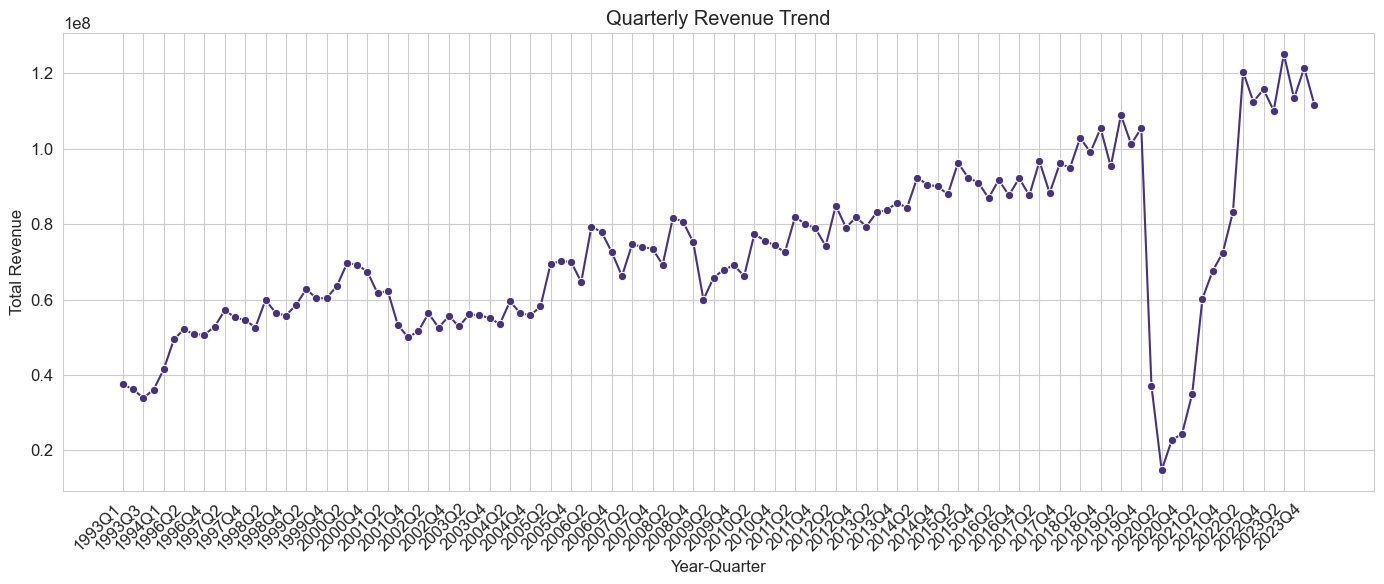

In [ ]:
# Group by year_quarter
quarterly_revenue = (
    df_clean.groupby('year_quarter')['revenue']
    .sum()
    .reset_index()
)

# Ensure proper sorting of quarters
quarterly_revenue['year_quarter'] = pd.Categorical(
    quarterly_revenue['year_quarter'],
    categories=sorted(quarterly_revenue['year_quarter'].unique(), key=lambda x: (int(x[:4]), int(x[-1]))),
    ordered=True
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=quarterly_revenue, x='year_quarter', y='revenue', marker='o')

# Alternate x-ticks for readability
tick_positions = range(0, len(quarterly_revenue), 2)  # every 4th quarter
plt.xticks(tick_positions, quarterly_revenue['year_quarter'].iloc[tick_positions], rotation=45, ha='right')

plt.title('Quarterly Revenue Trend')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(sorted(df_clean['Year'].unique()))

[1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [ ]:
def create_working_agg_df(df_clean):
    if 'period' not in df_clean.columns:
        df_clean = df_clean.copy()
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')

    agg_df = df_clean.groupby('period').agg({
        'fare': 'mean',
        'passengers': 'sum',
        'revenue': 'sum'
    }).sort_index()

    agg_df['log_revenue'] = np.log(agg_df['revenue'] + 1)
    agg_df['log_passengers'] = np.log(agg_df['passengers'] + 1)
    agg_df['revenue_per_passenger'] = agg_df['revenue'] / agg_df['passengers']

    print(f"agg_df: {agg_df.shape}, {agg_df.index.min()} to {agg_df.index.max()}")
    return agg_df

def calculate_model_metrics(actual, predicted):
    """Calculate comprehensive metrics for model evaluation"""
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]

    if len(actual_clean) == 0:
        return {'MAPE': float('inf'), 'RMSE': float('inf'), 'MAE': float('inf'),
                'R2': -float('inf'), 'Directional_Accuracy': 0, 'Performance_Score': -float('inf')}

    # MAPE (Mean Absolute Percentage Error)
    non_zero_mask = actual_clean != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((actual_clean[non_zero_mask] - predicted_clean[non_zero_mask]) / actual_clean[non_zero_mask])) * 100
    else:
        mape = float('inf')

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((actual_clean - predicted_clean) ** 2))

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(actual_clean - predicted_clean))

    # R² (Coefficient of Determination)
    r2 = r2_score(actual_clean, predicted_clean)

    # Directional Accuracy (for sequences longer than 1)
    if len(actual_clean) > 1:
        actual_direction = np.sign(np.diff(actual_clean))
        pred_direction = np.sign(np.diff(predicted_clean))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = 0

    # Performance Score
    # Option 1: Keep existing (negative MAPE)
    capped_mape = min(mape, 1000)
    performance_score = -capped_mape

    # Option 2: Use R² as primary score (uncomment to use this instead)
    # performance_score = r2

    return {
        'MAPE': mape,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Directional_Accuracy': directional_accuracy,
        'Performance_Score': performance_score
    }

# Helper functions to reduce duplication
def create_periods(train_start, train_end, test_start='2020Q1'):
    """Create period objects for date filtering"""
    return (
        pd.Period(train_start, freq='Q'),
        pd.Period(train_end, freq='Q'),
        pd.Period(test_start, freq='Q')
    )

def create_ml_features(df, target_var, features):
    """Create ML features for time series data"""
    df = df[[target_var]].copy()
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    if 'lag_1' in features:
        df['lag_1'] = df[target_var].shift(1)
    if 'lag_4' in features:
        df['lag_4'] = df[target_var].shift(4)
    if 'rolling_mean_4' in features:
        df['rolling_mean_4'] = df[target_var].shift(1).rolling(4).mean()
    if 'pct_change_1' in features:
        df['pct_change_1'] = df[target_var].pct_change(1)

    df['y'] = df[target_var]
    return df.dropna()

def split_data(df_feat, train_start_period, train_end_period, test_start_period):
    """Split data into train and test sets"""
    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)
    test_mask = df_feat.index >= test_start_period

    train_data = df_feat[train_mask]
    test_data = df_feat[test_mask]

    if len(train_data) < 20 or len(test_data) < 4:
        raise ValueError("Insufficient data")

    return train_data, test_data

def generate_test_configs():
    # Different target sets for different model types
    ml_targets = ['log_revenue', 'log_passengers', 'fare', 'revenue_per_passenger']  # Skip non-log versions
    arima_targets = ['revenue', 'passengers', 'fare', 'log_revenue', 'log_passengers', 'revenue_per_passenger']  # Keep all

    # Q4 of 2019 is the last quarter before data is skewed by COVID
    train_end = '2019Q4'
    starts = ['1993Q1', '1997Q1','2000Q1', '2005Q1', '2008Q1', '2013Q1']
    train_periods = [(start, train_end) for start in starts]

    # ML feature combinations
    # Other combinations were removed to reduce computation time and improve efficiency
    ml_feature_combinations = [
        ['quarter', 'lag_1'],
        ['quarter', 'lag_1', 'lag_4'],
        ['quarter', 'lag_1', 'rolling_mean_4'],
        ['year', 'quarter', 'lag_1'],
        ['year', 'quarter', 'lag_1', 'lag_4'],
        ['quarter', 'lag_4'],
        ['quarter', 'rolling_mean_4'],
        ['lag_1', 'lag_4'],
        ['quarter', 'pct_change_1'],
        ['lag_1', 'pct_change_1'],
    ]

    configs = []
    for train_start, train_end in train_periods:
        for model in ['XGBoostRegression', 'RandomForest', 'LinearRegression']:
            for target in ml_targets:
                for features in ml_feature_combinations:
                    configs.append((target, features, model, train_start, train_end))

        # ARIMA models - test all targets to find best one
        for target in arima_targets:
            # ARIMA does not need ml_feature_combinations since it is built into it
            configs.append((target, ['ARIMA_auto'], 'ARIMA', train_start, train_end))

    return configs

def fit_arima_model(train_data, target_var):
    """Fit ARIMA model with list comprehension"""
    ts = train_data[target_var]

    # Generate ARIMA configurations (base models)
    # p represents the autoregressive order
    # d represents the differencing order
    # q represents the moving average order
    arima_configs = [(p, d, q, None) for p in range(3) for d in range(2) for q in range(3)]

    # Generate SARIMA configurations (with seasonal components)
    sarima_configs = [
        (p, d, q, (P, D, Q, 4))
        for p in range(2) for d in range(2) for q in range(2)
        for P in range(2) for D in range(2) for Q in range(2)
        if not (P == 0 and D == 0 and Q == 0)  # Exclude when seasonal component is (0,0,0)
    ]

    # Combine all configurations
    all_configs = arima_configs + sarima_configs

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal = None

    for p, d, q, seasonal_order in all_configs:
        try:
            if seasonal_order is None:
                # Standard ARIMA
                model = ARIMA(ts, order=(p, d, q))
            else:
                # SARIMA
                model = ARIMA(ts, order=(p, d, q), seasonal_order=seasonal_order)

            fitted = model.fit()

            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_model = fitted
                best_order = (p, d, q)
                best_seasonal = seasonal_order

        except Exception as e:
            # Skip configurations that fail to fit
            continue

    if best_model:
        if best_seasonal:
            P, D, Q, s = best_seasonal
            best_model_name = f"SARIMA{best_order}({P},{D},{Q},{s})"
        else:
            best_model_name = f"ARIMA{best_order}"
        return best_model, best_model_name
    else:
        fallback_model = ARIMA(ts, order=(1, 1, 1)).fit()
        return fallback_model, "ARIMA(1,1,1)"

def test_arima_model(agg_df, target_var, features, train_start, train_end, test_index=None, verbose_every=None):
    """Test ARIMA model with consolidated logic"""
    train_start_period, train_end_period, test_start_period = create_periods(train_start, train_end)

    ts_data = agg_df[[target_var]].copy()

    train_data, test_data = split_data(ts_data, train_start_period, train_end_period, test_start_period)

    arima_model, model_name = fit_arima_model(train_data, target_var)

    # Make predictions
    forecast_steps = len(test_data)
    forecast = arima_model.forecast(steps=forecast_steps)
    actual_test_values = test_data[target_var].values

    # Calculate comprehensive metrics
    metrics = calculate_model_metrics(actual_test_values, forecast)

    should_print = verbose_every is None or (test_index is not None and test_index % verbose_every == 0)
    if should_print:
        test_prefix = f"Test {test_index}: " if test_index else ""
        print(f"  {test_prefix}Best model for {target_var}: {model_name}, MAPE: {metrics['MAPE']:.1f}%, RMSE: {metrics['RMSE']:.1f}, R²: {metrics['R2']:.3f}")

    return metrics, arima_model, ts_data

def test_ml_model(agg_df, target_var, features, model_type, train_start, train_end, test_index=None, verbose_every=None):
    """Test ML models"""
    train_start_period, train_end_period, test_start_period = create_periods(train_start, train_end)

    df_feat = create_ml_features(agg_df, target_var, features)
    train_data, test_data = split_data(df_feat, train_start_period, train_end_period, test_start_period)

    X_train = train_data[features]
    y_train = train_data['y']
    X_test = test_data[features]
    y_test = test_data['y']

    if model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'LinearRegression':
        model = LinearRegression()
    else:
        raise ValueError("Invalid model type")

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # Calculate comprehensive metrics
    metrics = calculate_model_metrics(y_test.values, pred)

    # Print only if verbose conditions are met
    should_print = verbose_every is None or (test_index is not None and test_index % verbose_every == 0)
    if should_print:
        test_prefix = f"Test {test_index}: " if test_index else ""
        feature_str = '+'.join(features)
        # Include R² in the output
        print(f"  {test_prefix}Best model for {target_var}: {model_type}[{feature_str}], MAPE: {metrics['MAPE']:.1f}%, R²: {metrics['R2']:.3f}")

    return metrics, model, df_feat

def test_single_combination(agg_df, target_var, features, model_type, train_start, train_end, test_index=None, total_tests=None, verbose_every=100):
    """Unified testing function using consolidated helper functions"""
    if model_type == 'ARIMA':
        metrics, model, df_feat = test_arima_model(agg_df, target_var, features, train_start, train_end, test_index, verbose_every)
    else:
        metrics, model, df_feat = test_ml_model(agg_df, target_var, features, model_type, train_start, train_end, test_index, verbose_every)

    return metrics, model, df_feat

def test_high_combinations(agg_df, verbose_every=100):
    results = []
    models = {}

    test_configs = generate_test_configs()
    print(f"Testing {len(test_configs)} configurations...")
    if verbose_every and verbose_every > 0:
        print(f"Showing detailed results every {verbose_every} tests")
    elif verbose_every == 0:
        print(f"Running in quiet mode - only showing progress every {verbose_every} tests")

    for i, (target_var, features, model_type, train_start, train_end) in enumerate(test_configs):
        try:
            metrics, model, df_feat = test_single_combination(
                agg_df, target_var, features, model_type, train_start, train_end,
                test_index=i+1, total_tests=len(test_configs), verbose_every=verbose_every
            )

            config_name = f"{model_type}_{target_var}_{'+'.join(features)}_{train_start}-{train_end}"

            results.append({
                'Config': config_name,
                'Target': target_var,
                'Features': features,
                'Model': model_type,
                'Train_Period': f"{train_start}-{train_end}",
                'MAPE': metrics['MAPE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'Directional_Accuracy': metrics['Directional_Accuracy'],
                'Performance_Score': metrics['Performance_Score']
            })

            models[config_name] = {
                'model': model,
                'df_feat': df_feat,
                'target_var': target_var,
                'features': features,
                'metrics': metrics
            }

            # Print progress every 100 configs
            if (i + 1) % verbose_every == 0:
                print(f"  {i+1:2d}/{len(test_configs)} configs tested...")

        except Exception as e:
            if model_type == 'ARIMA':
                print(f"  ARIMA failed for {target_var} {features[0]}: {str(e)[:50]}")
            continue

    results_df = pd.DataFrame(results)
    # Sort by Performance Score (higher is better)
    best_config = results_df.loc[results_df['Performance_Score'].idxmax()]
    best_model_info = models[best_config['Config']]

    print(f"\nBest: {best_config['Config']}")
    print(f"MAPE = {best_config['MAPE']:.1f}%, R² = {best_config['R2']:.3f}, Directional Accuracy = {best_config['Directional_Accuracy']:.1f}%")

    return best_config, best_model_info, results_df

def create_forecast_features(features, next_quarter, next_year, forecasts, i, current_value, recent_values):
    """Create feature dictionary for forecasting"""
    feature_dict = {}

    if 'quarter' in features:
        feature_dict['quarter'] = next_quarter
    if 'year' in features:
        feature_dict['year'] = next_year
    if 'lag_1' in features:
        feature_dict['lag_1'] = forecasts[i-1] if i > 0 else current_value
    if 'lag_4' in features:
        feature_dict['lag_4'] = forecasts[i-4] if i >= 4 else recent_values[-(4-i)] if i < 4 else recent_values[-4]
    if 'rolling_mean_4' in features:
        if i > 0:
            recent_and_forecast = recent_values + forecasts[:i]
            feature_dict['rolling_mean_4'] = np.mean(recent_and_forecast[-4:])
        else:
            feature_dict['rolling_mean_4'] = np.mean(recent_values[-4:])
    if 'pct_change_1' in features:
        if i > 0:
            prev_value = forecasts[i-1]
        else:
            prev_value = recent_values[-1]
        current_pred_value = forecasts[i-1] if i > 0 else current_value
        feature_dict['pct_change_1'] = (current_pred_value - prev_value) / prev_value if prev_value != 0 else 0

    return feature_dict

def generate_forecast_with_best(agg_df, best_config, best_model_info, periods=8):
    model = best_model_info['model']
    target_var = best_model_info['target_var']
    features = best_model_info['features']

    # Check if it's an ARIMA model
    if hasattr(model, 'forecast') and features[0] == 'ARIMA_auto':
        forecasts = model.forecast(steps=periods)

        if target_var.startswith('log_'):
            forecasts = np.exp(forecasts) - 1

        forecasts = list(forecasts)  # Convert to list
    else:
        # ML model forecasting (using consolidated helper function)
        forecasts = []
        current_value = agg_df[target_var].iloc[-1]
        last_quarter = agg_df.index.max().quarter
        last_year = agg_df.index.max().year
        recent_values = list(agg_df[target_var].iloc[-8:])

        for i in range(periods):
            next_quarter = ((last_quarter + i - 1) % 4) + 1
            next_year = last_year + (last_quarter + i - 1) // 4

            feature_dict = create_forecast_features(features, next_quarter, next_year, forecasts, i, current_value, recent_values)
            pred_df = pd.DataFrame([feature_dict])[features]
            forecast = model.predict(pred_df)[0]
            forecasts.append(forecast)

    if target_var == 'log_revenue':
        if not (hasattr(model, 'forecast') and features[0] == 'ARIMA_auto'):
            forecasts = [np.exp(f) - 1 for f in forecasts]
        revenue_forecasts = forecasts
    elif target_var == 'revenue':
        revenue_forecasts = forecasts
    else:
        current_revenue = agg_df['revenue'].iloc[-1]
        current_target = agg_df[target_var].iloc[-1]
        conversion_ratio = current_revenue / current_target if current_target != 0 else 1
        revenue_forecasts = [f * conversion_ratio for f in forecasts]

    return revenue_forecasts

# def train_evaluate_linear_regression(df, target_var, features):
#     X = df[features]
#     y = df[target_var]

#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)

#     metrics = calculate_model_metrics(y_test.values, preds)
#     return model, metrics

agg_df = create_working_agg_df(df_clean)

# Control verbosity here:
best_config, best_model_info, results_df = test_high_combinations(agg_df, verbose_every=100)

# Performance analysis
print("\nModel Performance by Type:")
for model_type in ['XGBoostRegression', 'RandomForest', 'LinearRegression', 'ARIMA']:
    model_results = results_df[results_df['Model'] == model_type].sort_values('Performance_Score', ascending=False)
    if len(model_results) > 0:
        best_model = model_results.iloc[0]
        print(f"\n{model_type}:")
        print(f"  Best MAPE: {best_model['MAPE']:.1f}%")
        print(f"  Best R²: {best_model['R2']:.3f}")
        print(f"  Best Directional Accuracy: {best_model['Directional_Accuracy']:.1f}%")
        print(f"  Best Config: {best_model['Config']}")
        if len(model_results) > 1:
            print(f"  Top 3 MAPE scores: {model_results['MAPE'].head(3).tolist()}")
            print(f"  Top 3 R² scores: {model_results['R2'].head(3).tolist()}")

forecasts = generate_forecast_with_best(agg_df, best_config, best_model_info)

current_revenue = agg_df['revenue'].iloc[-1]
forecast_final = forecasts[-1]
annual_growth = ((forecast_final / current_revenue) ** 0.5 - 1) * 100

agg_df: (118, 6), 1993Q1 to 2024Q1
Testing 756 configurations...
Showing detailed results every 100 tests
  Test 100: Best model for log_passengers: LinearRegression[lag_1+pct_change_1], MAPE: 0.1%, R²: 0.999
  100/756 configs tested...
  Test 200: Best model for revenue_per_passenger: RandomForest[year+quarter+lag_1], MAPE: 8.0%, R²: 0.583
  200/756 configs tested...
  Test 300: Best model for log_revenue: RandomForest[lag_1+lag_4], MAPE: 2.5%, R²: 0.185
  300/756 configs tested...
  Test 400: Best model for fare: XGBoostRegression[quarter+lag_1+lag_4], MAPE: 7.6%, R²: 0.470
  400/756 configs tested...
  Test 500: Best model for passengers: SARIMA(0, 1, 0)(1,1,0,4), MAPE: 79.4%, RMSE: 167075.8, R²: -0.499
  500/756 configs tested...
  Test 600: Best model for log_passengers: LinearRegression[quarter+lag_4], MAPE: 5.1%, R²: -1.255
  600/756 configs tested...
  Test 700: Best model for fare: RandomForest[lag_1+pct_change_1], MAPE: 12.5%, R²: -0.108
  700/756 configs tested...

Best: Lin

In [ ]:
display(results_df)
results_df.describe()

,Config,Target,Features,Model,Train_Period,MAPE,RMSE,MAE,R2,Directional_Accuracy,Performance_Score,Start_Train,End_Train,Train_Length,Feature_Combo
0,XGBoostRegression_log_revenue_quarter+lag_1_1993Q1-2019Q4,log_revenue,"[quarter, lag_1]",XGBoostRegression,1993Q1-2019Q4,1.649522,0.389000,0.289161,0.668855,75.00,-1.649522,1993Q1,2019Q4,NaN,"quarter, lag_1"
1,XGBoostRegression_log_revenue_quarter+lag_1+lag_4_1993Q1-2019Q4,log_revenue,"[quarter, lag_1, lag_4]",XGBoostRegression,1993Q1-2019Q4,2.136076,0.494782,0.373913,0.464270,75.00,-2.136076,1993Q1,2019Q4,NaN,"quarter, lag_1, lag_4"
2,XGBoostRegression_log_revenue_quarter+lag_1+rolling_mean_4_1993Q1-2019Q4,log_revenue,"[quarter, lag_1, rolling_mean_4]",XGBoostRegression,1993Q1-2019Q4,2.068812,0.499076,0.361162,0.454930,75.00,-2.068812,1993Q1,2019Q4,NaN,"quarter, lag_1, rolling_mean_4"
3,XGBoostRegression_log_revenue_year+quarter+lag_1_1993Q1-2019Q4,log_revenue,"[year, quarter, lag_1]",XGBoostRegression,1993Q1-2019Q4,2.473557,0.635377,0.427285,0.116550,75.00,-2.473557,1993Q1,2019Q4,NaN,"year, quarter, lag_1"
4,XGBoostRegression_log_revenue_year+quarter+lag_1+lag_4_1993Q1-2019Q4,log_revenue,"[year, quarter, lag_1, lag_4]",XGBoostRegression,1993Q1-2019Q4,2.530444,0.638793,0.438715,0.107024,75.00,-2.530444,1993Q1,2019Q4,NaN,"year, quarter, lag_1, lag_4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,ARIMA_passengers_ARIMA_auto_2013Q1-2019Q4,passengers,[ARIMA_auto],ARIMA,2013Q1-2019Q4,79.392657,166704.016127,123800.004124,-0.492382,56.25,-79.392657,2013Q1,2019Q4,NaN,ARIMA_auto
752,ARIMA_fare_ARIMA_auto_2013Q1-2019Q4,fare,[ARIMA_auto],ARIMA,2013Q1-2019Q4,13.852690,38.030773,27.943748,-0.358674,68.75,-13.852690,2013Q1,2019Q4,NaN,ARIMA_auto
753,ARIMA_log_revenue_ARIMA_auto_2013Q1-2019Q4,log_revenue,[ARIMA_auto],ARIMA,2013Q1-2019Q4,3.112631,0.830022,0.534996,-0.507644,68.75,-3.112631,2013Q1,2019Q4,NaN,ARIMA_auto
754,ARIMA_log_passengers_ARIMA_auto_2013Q1-2019Q4,log_passengers,[ARIMA_auto],ARIMA,2013Q1-2019Q4,3.863162,0.690415,0.462268,-0.588720,56.25,-3.863162,2013Q1,2019Q4,NaN,ARIMA_auto


,MAPE,RMSE,MAE,R2,Directional_Accuracy,Performance_Score,Train_Length
count,756.000000,7.560000e+02,7.560000e+02,756.000000,756.000000,756.000000,0.0
mean,7.816070,3.674561e+05,2.711736e+05,0.114307,57.118056,-7.816070,NaN
std,12.325645,4.095971e+06,3.023716e+06,0.410107,16.346214,12.325645,NaN
min,0.054884,1.538107e-02,9.497874e-03,-1.560263,18.750000,-114.558393,NaN
25%,2.856582,6.082491e-01,4.064147e-01,-0.201356,50.000000,-9.761023,NaN
50%,4.146584,2.993325e+00,2.067215e+00,0.119130,56.250000,-4.146584,NaN
75%,9.761023,2.781731e+01,2.121296e+01,0.455104,68.750000,-2.856582,NaN
max,114.558393,4.652107e+07,3.566651e+07,0.999482,100.000000,-0.054884,NaN


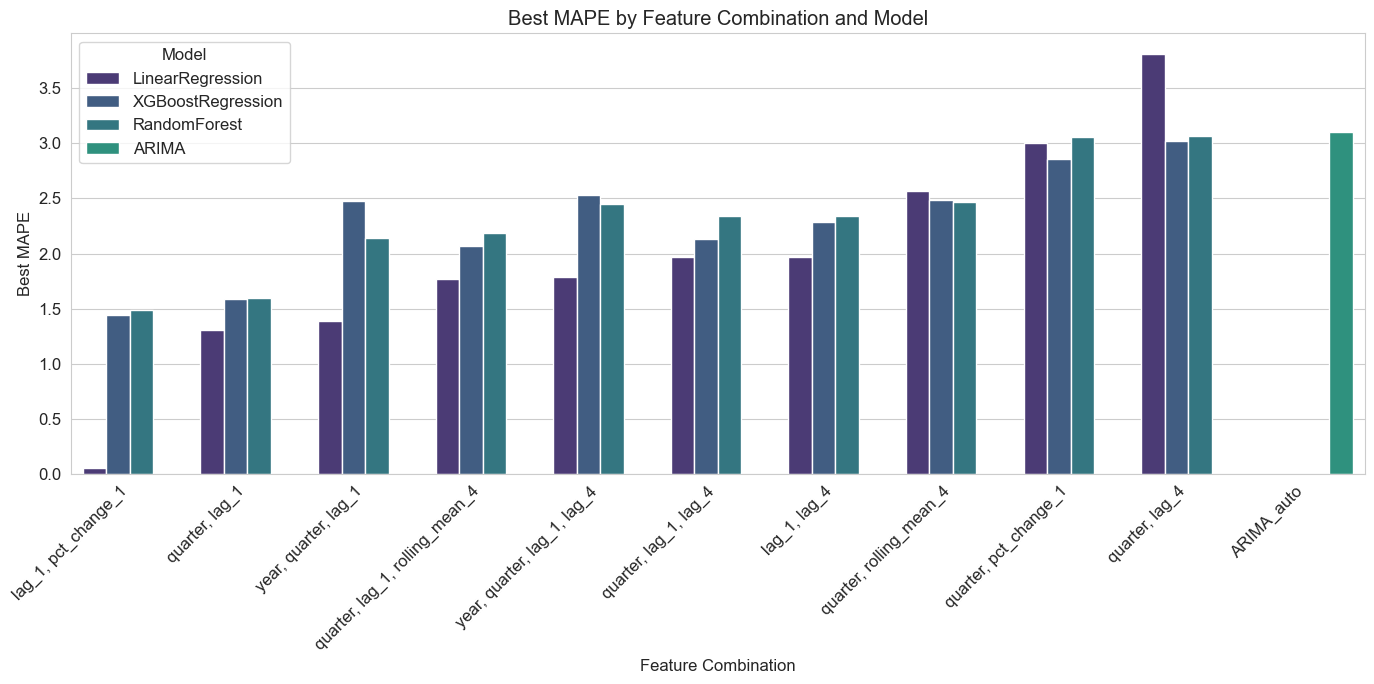

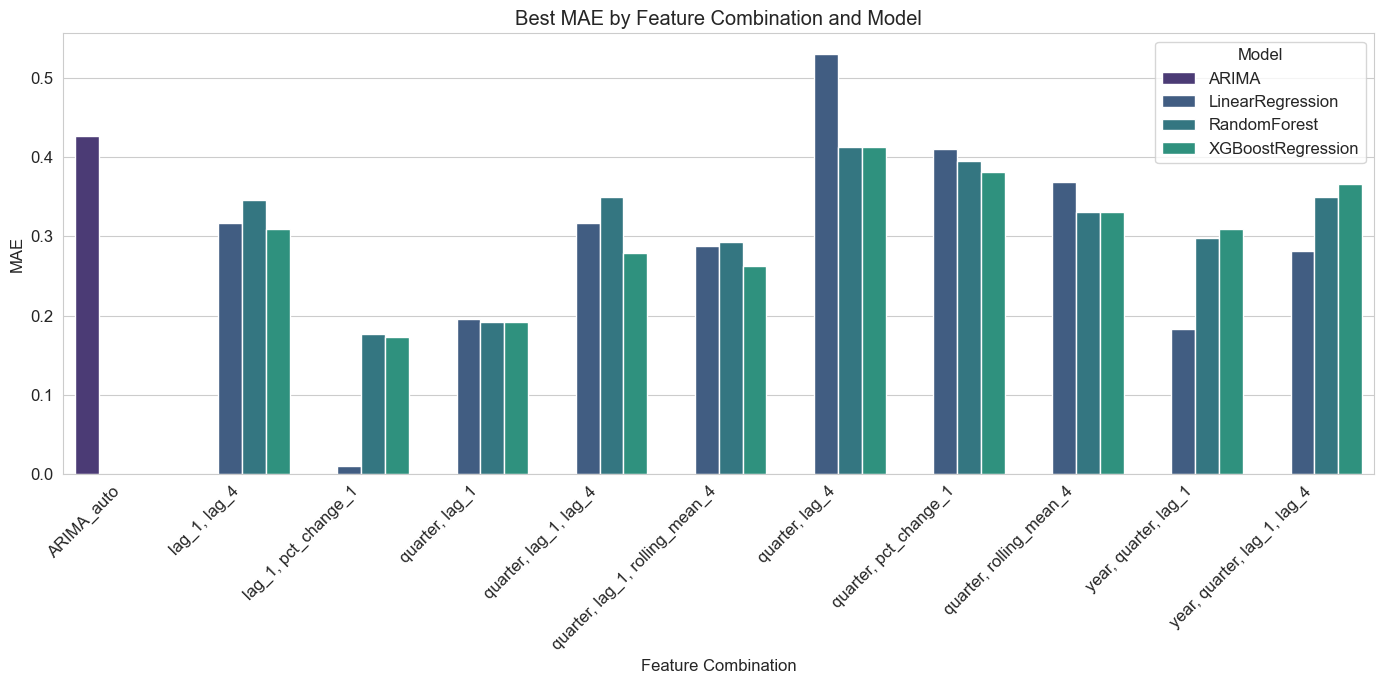

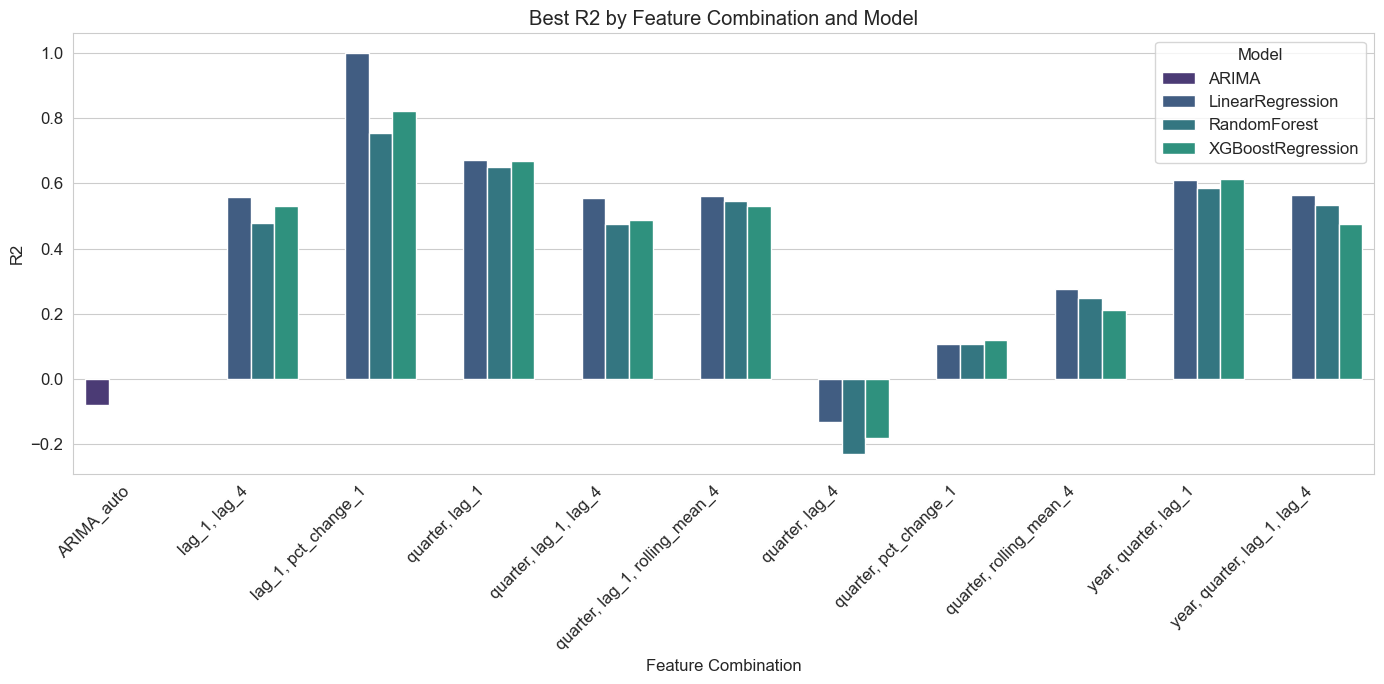

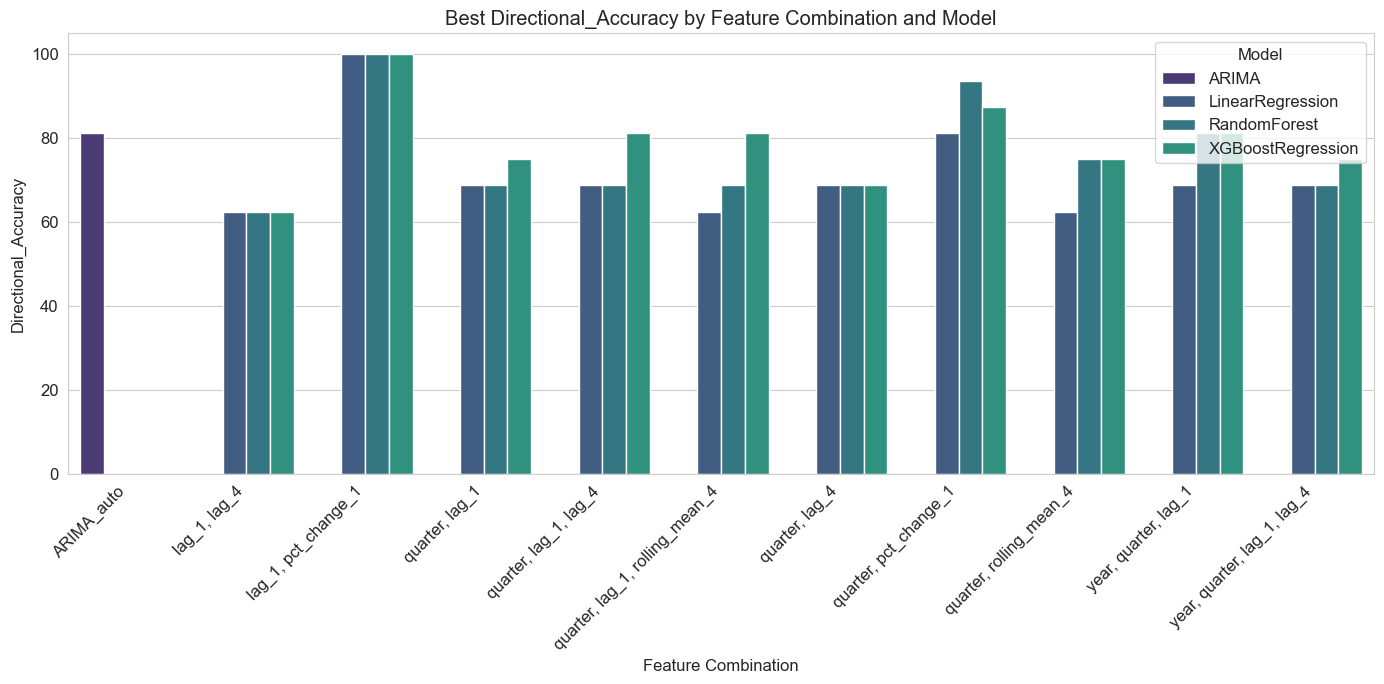

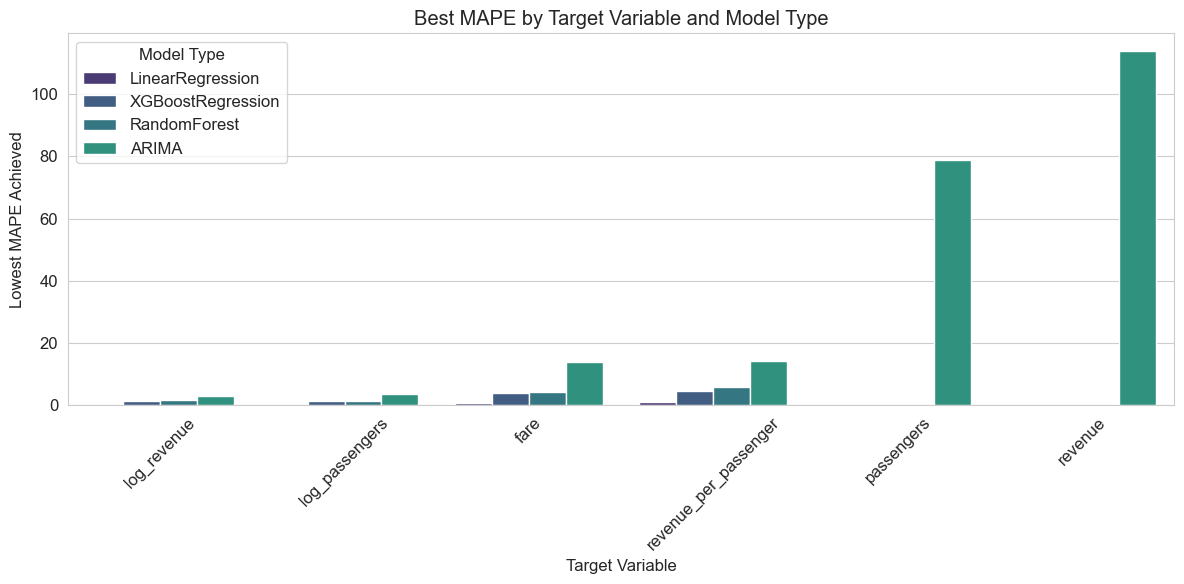

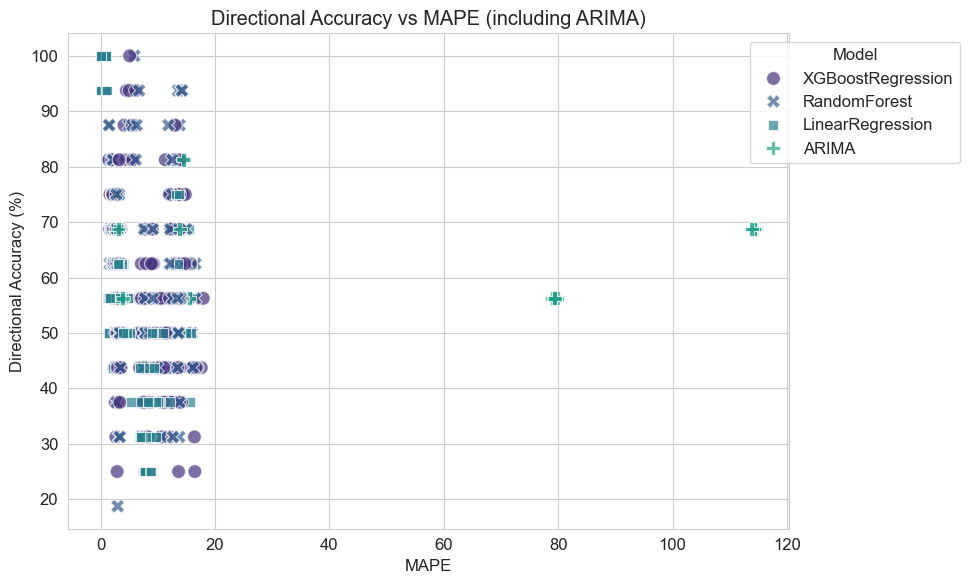

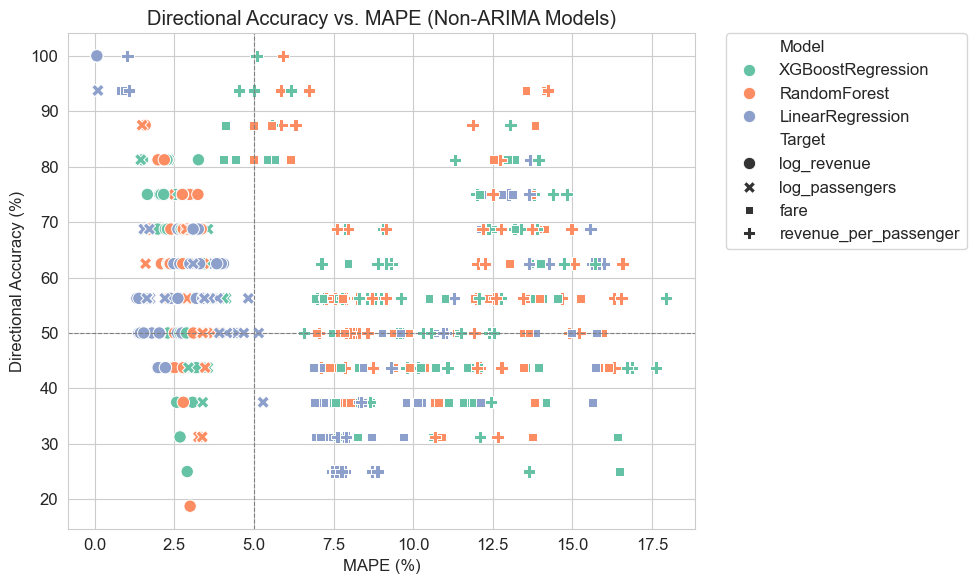

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Clean feature names (convert list of features to strings for grouping)
results_df['Feature_Combo'] = results_df['Features'].astype(str).str.replace('[\[\]\']', '', regex=True)
# For each (Feature_Combo, Model), get the best (lowest) MAPE
best_mape_by_feature_model = (
    results_df
    .groupby(['Feature_Combo', 'Model'])['MAPE']
    .min()
    .reset_index()
)
# Sort by overall best MAPE to make the plot more readable
best_mape_by_feature_model = best_mape_by_feature_model.sort_values(by='MAPE')
# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=best_mape_by_feature_model,
            x='Feature_Combo',
            y='MAPE',
            hue='Model')
plt.title('Best MAPE by Feature Combination and Model')
plt.xlabel('Feature Combination')
plt.ylabel('Best MAPE')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Convert Features list to string for grouping
results_df['Features_str'] = results_df['Features'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
metric = 'MAE'
maximize = False  # For MAE, lower is better
grouped = results_df.groupby(['Features_str', 'Model'])[metric]
if maximize:
    idx = grouped.idxmax()
else:
    idx = grouped.idxmin()
idx = idx.dropna()
best_df = results_df.loc[idx.values]
plt.figure(figsize=(14, 7))
sns.barplot(data=best_df, x='Features_str', y=metric, hue='Model')
plt.xticks(rotation=45, ha='right')
plt.title(f'Best {metric} by Feature Combination and Model')
plt.ylabel(metric)
plt.xlabel('Feature Combination')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()


# Convert Features list to string for grouping (simple string join)
results_df['Features_str'] = results_df['Features'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
metric = 'R2'
maximize = True  # For R2, higher is better
grouped = results_df.groupby(['Features_str', 'Model'])[metric]
if maximize:
    idx = grouped.idxmax()
else:
    idx = grouped.idxmin()
idx = idx.dropna()
best_df = results_df.loc[idx.values]
plt.figure(figsize=(14, 7))
sns.barplot(data=best_df, x='Features_str', y=metric, hue='Model')
plt.xticks(rotation=45, ha='right')
plt.title(f'Best {metric} by Feature Combination and Model')
plt.ylabel(metric)
plt.xlabel('Feature Combination')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()


# Ensure Features column is stringified
results_df['Features_str'] = results_df['Features'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
metric = 'Directional_Accuracy'
maximize = True  # Higher is better for Directional Accuracy
grouped = results_df.groupby(['Features_str', 'Model'])[metric]
if maximize:
    idx = grouped.idxmax()
else:
    idx = grouped.idxmin()
idx = idx.dropna()
best_df = results_df.loc[idx.values]
plt.figure(figsize=(14, 7))
sns.barplot(data=best_df, x='Features_str', y=metric, hue='Model')
plt.xticks(rotation=45, ha='right')
plt.title(f'Best {metric} by Feature Combination and Model')
plt.ylabel(metric)
plt.xlabel('Feature Combination')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()


# Get best (lowest) MAPE per (Target, Model)
best_mape_per_target_model = (
    results_df
    .groupby(['Target', 'Model'])['MAPE']
    .min()
    .reset_index()
)
# Sort by Target for consistent order
best_mape_per_target_model = best_mape_per_target_model.sort_values(by='MAPE')
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=best_mape_per_target_model,
            x='Target',
            y='MAPE',
            hue='Model')
plt.title('Best MAPE by Target Variable and Model Type')
plt.ylabel('Lowest MAPE Achieved')
plt.xlabel('Target Variable')
plt.xticks(rotation=45)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='MAPE',
    y='Directional_Accuracy',
    hue='Model',
    style='Model',
    s=100,
    alpha=0.7
)
plt.title('Directional Accuracy vs MAPE (including ARIMA)')
plt.xlabel('MAPE')
plt.ylabel('Directional Accuracy (%)')
plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# Filter out ARIMA models
non_arima_df = results_df[~results_df['Model'].str.contains('ARIMA')]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=non_arima_df,
    x='MAPE',
    y='Directional_Accuracy',
    hue='Model',
    style='Target',
    palette='Set2',
    s=80
)
plt.title('Directional Accuracy vs. MAPE (Non-ARIMA Models)')
plt.xlabel('MAPE (%)')
plt.ylabel('Directional Accuracy (%)')
plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=50, color='gray', linestyle='--', linewidth=0.8)
# Move legend outside the plot on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


Best Model Performance:
MAPE: 0.1%
R²: 0.999
Directional Accuracy: 100.0%
Current: $111,662,606
2-Year: $111,893,208
Growth: 0.1032%


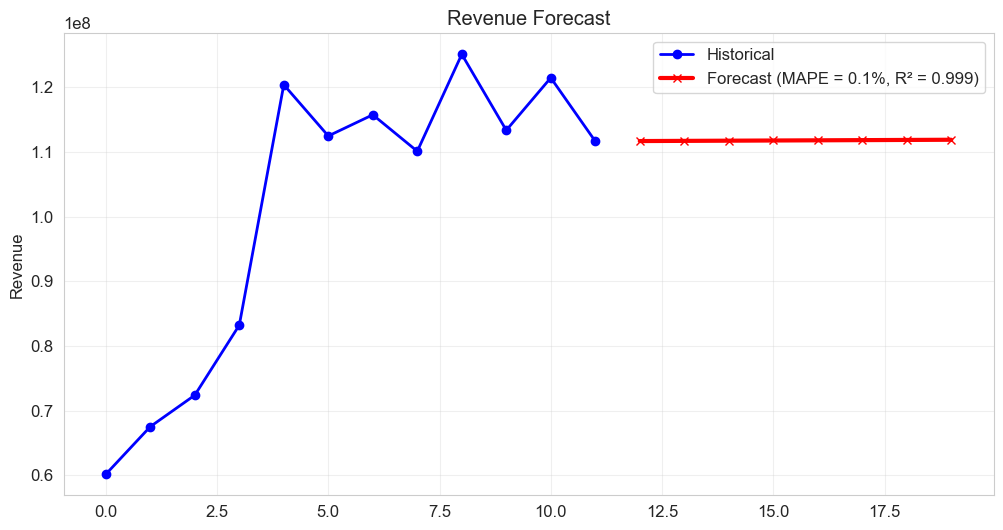

In [ ]:
print(f"\nBest Model Performance:")
print(f"MAPE: {best_config['MAPE']:.1f}%")
print(f"R²: {best_config['R2']:.3f}")
print(f"Directional Accuracy: {best_config['Directional_Accuracy']:.1f}%")
print(f"Current: ${current_revenue:,.0f}")
print(f"2-Year: ${forecast_final:,.0f}")
print(f"Growth: {annual_growth:.4f}%")

plt.figure(figsize=(12, 6))
recent = agg_df['revenue'].iloc[-12:]
plt.plot(range(len(recent)), recent, 'b-o', label='Historical', linewidth=2)
plt.plot(range(len(recent), len(recent) + 8), forecasts, 'r-x',
          label=f'Forecast (MAPE = {best_config["MAPE"]:.1f}%, R² = {best_config["R2"]:.3f})', linewidth=3)
plt.title('Revenue Forecast')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def print_top_configurations(results_df, metric='MAPE', top_n=10):
    """Print top configurations in table format"""

    metric_info = {
        'MAPE': {'ascending': True, 'format': '.2f', 'label': 'MAPE (%)'},
        'R2': {'ascending': False, 'format': '.2f', 'label': 'R²'},
        'Directional_Accuracy': {'ascending': False, 'format': '.1f', 'label': 'Dir_Acc (%)'},
        'RMSE': {'ascending': True, 'format': '.0f', 'label': 'RMSE'},
        'MAE': {'ascending': True, 'format': '.2f', 'label': 'MAE'},
        'Performance_Score': {'ascending': False, 'format': '.2f', 'label': 'Perf_Score'}
    }

    ascending = metric_info[metric]['ascending']

    top_results = results_df.sort_values(metric, ascending=ascending).head(top_n).copy()

    top_results['Short_Config'] = (
        top_results['Model'].str.replace('Regression', '').str.replace('Forest', 'F') + '_' +
        top_results['Target'] + '_' +
        top_results['Features'].apply(lambda x: '+'.join(x)) + '_' +
        top_results['Train_Period'].str[:]
    )

    if metric == 'MAPE':
        display_cols = ['Short_Config', 'MAPE', 'R2', 'Directional_Accuracy']
        col_labels = ['Configuration', 'MAPE (%)', 'R²', 'Dir_Acc (%)']
    elif metric == 'R2':
        display_cols = ['Short_Config', 'R2', 'MAPE', 'Directional_Accuracy']
        col_labels = ['Configuration', 'R²', 'MAPE (%)', 'Dir_Acc (%)']
    else:
        display_cols = ['Short_Config', metric, 'MAPE', 'R2']
        col_labels = ['Configuration', metric_info[metric]['label'], 'MAPE (%)', 'R²']

    table = top_results[display_cols].copy()
    table.columns = col_labels

    for col in table.columns[1:]:
        table[col] = table[col].round(2)

    table.index = range(1, len(table) + 1)

    sort_direction = "Ascending" if ascending else "Descending"
    print(f"\n{'='*90}")
    print(f"TOP {top_n} BY {metric.upper()} ({sort_direction})")
    print('='*90)
    print(table.to_string(index=True, index_names=['Rank']))
    print('='*90)

def print_best_accuracy(results_df, top_n=10):
    print_top_configurations(results_df, 'MAPE', top_n)

def print_best_fit(results_df, top_n=10):
    print_top_configurations(results_df, 'R2', top_n)

def print_best_trends(results_df, top_n=10):
    print_top_configurations(results_df, 'Directional_Accuracy', top_n)

print_best_accuracy(results_df)
print_best_fit(results_df)
print_top_configurations(results_df, 'RMSE')


TOP 10 BY MAPE (Ascending)
                                             Configuration  MAPE (%)   R²  Dir_Acc (%)
1      Linear_log_revenue_lag_1+pct_change_1_1993Q1-2019Q4      0.05  1.0       100.00
2      Linear_log_revenue_lag_1+pct_change_1_2005Q1-2019Q4      0.06  1.0       100.00
3      Linear_log_revenue_lag_1+pct_change_1_1997Q1-2019Q4      0.06  1.0       100.00
4      Linear_log_revenue_lag_1+pct_change_1_2000Q1-2019Q4      0.06  1.0       100.00
5      Linear_log_revenue_lag_1+pct_change_1_2008Q1-2019Q4      0.06  1.0       100.00
6      Linear_log_revenue_lag_1+pct_change_1_2013Q1-2019Q4      0.06  1.0       100.00
7   Linear_log_passengers_lag_1+pct_change_1_1993Q1-2019Q4      0.09  1.0        93.75
8   Linear_log_passengers_lag_1+pct_change_1_1997Q1-2019Q4      0.09  1.0        93.75
9   Linear_log_passengers_lag_1+pct_change_1_2000Q1-2019Q4      0.09  1.0        93.75
10  Linear_log_passengers_lag_1+pct_change_1_2005Q1-2019Q4      0.09  1.0        93.75

TOP 10 BY R2 (